### R CART实现

CART在R中的实现为RPART库 (Recursive Partitioning And Regression Trees)，下面简单介绍其调用方式，主要参考[CART Model: Decision Tree Essentials](http://www.sthda.com/english/articles/35-statistical-machine-learning-essentials/141-cart-model-decision-tree-essentials/)

#### Classification Trees Demo

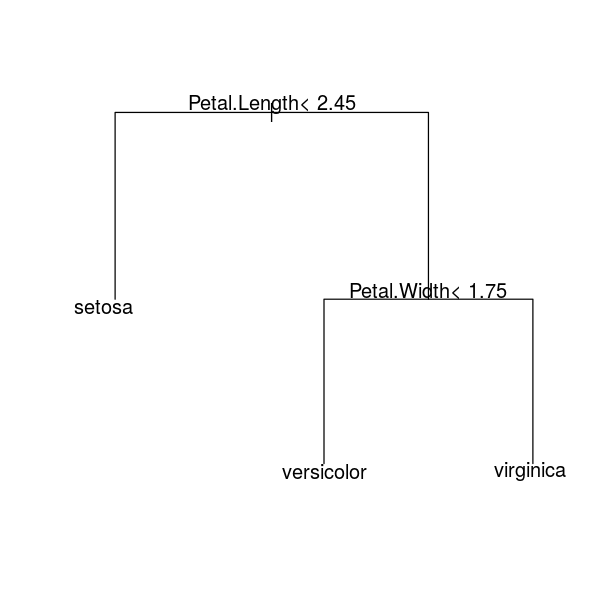

In [3]:
library(rpart)
options(repr.plot.width=5, repr.plot.height=5)  # plot size
model <- rpart(Species ~., data = iris)
par(xpd = NA) # otherwise on some devices the text is clipped
plot(model)
text(model, digits = 3)

In [8]:
print(model, digits=3)

n= 150 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 150 100 setosa (0.3333 0.3333 0.3333)  
  2) Petal.Length< 2.45 50   0 setosa (1.0000 0.0000 0.0000) *
  3) Petal.Length>=2.45 100  50 versicolor (0.0000 0.5000 0.5000)  
    6) Petal.Width< 1.75 54   5 versicolor (0.0000 0.9074 0.0926) *
    7) Petal.Width>=1.75 46   1 virginica (0.0000 0.0217 0.9783) *


In [9]:
# 预测
newdata <- data.frame(
  Sepal.Length = 6.5, Sepal.Width = 3.0,
  Petal.Length = 5.2, Petal.Width = 2.0
)
model %>% predict(newdata, "class") 

1 
virginica 
Levels: setosa versicolor virginica

#### Classfication Trees Pruning

In [12]:
# Load the data and remove NAs
data("PimaIndiansDiabetes2", package = "mlbench")
PimaIndiansDiabetes2 <- na.omit(PimaIndiansDiabetes2)
# Inspect the data
sample_n(PimaIndiansDiabetes2, 3)
# Split the data into training and test set
set.seed(123)
training.samples <- PimaIndiansDiabetes2$diabetes %>% 
  createDataPartition(p = 0.8, list = FALSE)
train.data  <- PimaIndiansDiabetes2[training.samples, ]
test.data <- PimaIndiansDiabetes2[-training.samples, ]

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
0,78,88,29,40,36.9,0.434,21,neg
1,111,62,13,182,24.0,0.138,23,neg
7,97,76,32,91,40.9,0.871,32,pos


注：关于管道操作符`%>%`，可以参考[stackoverflow](https://stackoverflow.com/questions/24536154/what-does-mean-in-r)。简单说就是为了应付函数嵌套的问题，如`iris %>% head()`其实就等同于`head(iris)`。所以，同样地，这里`PimaIndiansDiabetes2$diabetes %>% createDataPartition(p = 0.8, list = FALSE)`就等同于`createDataPartition(PimaIndiansDiabetes2$diabetes， p = 0.8, list = FALSE)`

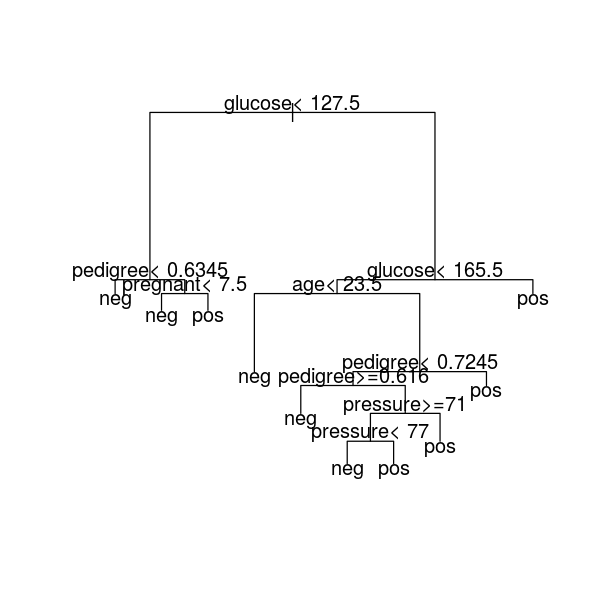

In [13]:
# Build the model
set.seed(123)
model1 <- rpart(diabetes ~., data = train.data, method = "class")
# Plot the trees
par(xpd = NA) # Avoid clipping the text in some device
plot(model1)
text(model1, digits = 3)

In [14]:
# Make predictions on the test data
predicted.classes <- model1 %>% 
  predict(test.data, type = "class")
head(predicted.classes)

21  25  28  29  32  36 
neg pos neg pos pos neg 
Levels: neg pos

In [15]:
# Compute model accuracy rate on test data
mean(predicted.classes == test.data$diabetes)

[1] 0.7820513

剪枝算法。

Briefly, our goal here is to see if a smaller subtree can give us comparable results to the fully grown tree. If yes, we should go for the simpler tree because it reduces the likelihood of overfitting.

One possible robust strategy of pruning the tree (or stopping the tree to grow) consists of avoiding splitting a partition if the split does not significantly improves the overall quality of the model.
In rpart package, this is controlled by the complexity parameter (cp), which imposes a penalty to the tree for having two many splits. The default value is 0.01. The higher the cp, the smaller the tree.

A too small value of cp leads to overfitting and a too large cp value will result to a too small tree. Both cases decrease the predictive performance of the model.
An optimal cp value can be estimated by testing different cp values and using cross-validation approaches to determine the corresponding prediction accuracy of the model. The best cp is then defined as the one that maximize the cross-validation accuracy (Chapter @ref(cross-validation)).

Pruning can be easily performed in the caret package workflow, which invokes the rpart method for automatically testing different possible values of cp, then choose the optimal cp that maximize the cross-validation (“cv”) accuracy, and fit the final best CART model that explains the best our data.

You can use the following arguments in the function train() [from caret package]:

    trControl, to set up 10-fold cross validation
    tuneLength, to specify the number of possible cp values to evaluate. Default value is 3, here we’ll use 10.


,cp
2,0.03205128


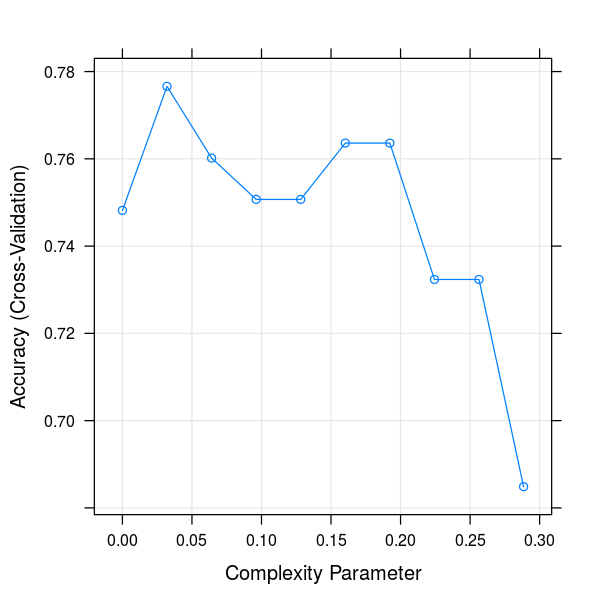

In [19]:
# CV剪枝
set.seed(123)
model2 <- train(
  diabetes ~., data = train.data, method = "rpart",
  trControl = trainControl("cv", number = 10),
  tuneLength = 10
  )
# Plot model accuracy vs different values of
# cp (complexity parameter)
plot(model2)
# Print the best tuning parameter cp that
# maximizes the model accuracy
model2$bestTune

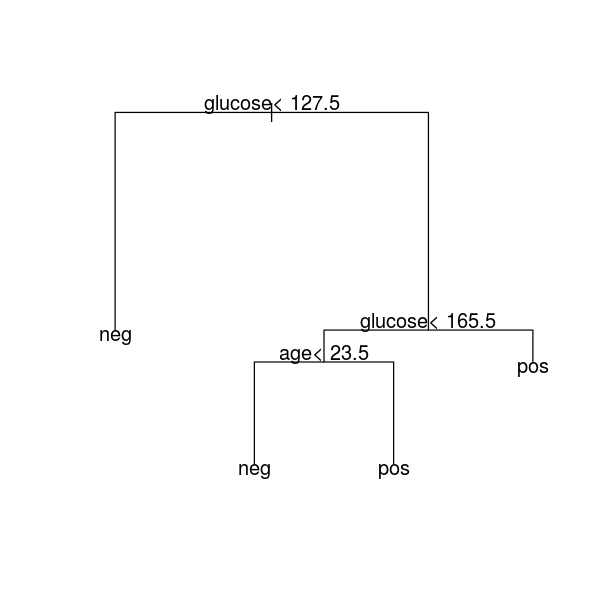

In [20]:
# Plot the final tree model
par(xpd = NA) # Avoid clipping the text in some device
plot(model2$finalModel)
text(model2$finalModel,  digits = 3)

In [21]:
model2$finalModel

n= 314 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 314 104 neg (0.6687898 0.3312102)  
   2) glucose< 127.5 188  26 neg (0.8617021 0.1382979) *
   3) glucose>=127.5 126  48 pos (0.3809524 0.6190476)  
     6) glucose< 165.5 88  44 neg (0.5000000 0.5000000)  
      12) age< 23.5 16   1 neg (0.9375000 0.0625000) *
      13) age>=23.5 72  29 pos (0.4027778 0.5972222) *
     7) glucose>=165.5 38   4 pos (0.1052632 0.8947368) *

In [22]:
# Make predictions on the test data
predicted.classes <- model2 %>% predict(test.data)
# Compute model accuracy rate on test data
mean(predicted.classes == test.data$diabetes)

[1] 0.7948718

>From the output above, it can be seen that the best value for the complexity parameter (cp) is 0.032, allowing a simpler tree, easy to interpret, with an overall accuracy of 79%, which is comparable to the accuracy (78%) that we have obtained with the full tree. The prediction accuracy of the pruned tree is even better compared to the full tree.

>Taken together, we should go for this simpler model.


#### Regression trees

这里使用RMSE是与平方误差是一致的，即得到最小二乘回归树

In [23]:
# Load the data
data("Boston", package = "MASS")
# Inspect the data
sample_n(Boston, 3)
# Split the data into training and test set
set.seed(123)
training.samples <- Boston$medv %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data  <- Boston[training.samples, ]
test.data <- Boston[-training.samples, ]

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.22969,0,10.59,0,0.489,6.326,52.5,4.3549,4,277,18.6,394.87,10.97,24.4
4.89822,0,18.10,0,0.631,4.970,100.0,1.3325,24,666,20.2,375.52,3.26,50.0
0.13960,0,8.56,0,0.520,6.167,90.0,2.4210,5,384,20.9,392.69,12.33,20.1


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

cp
0.007165585


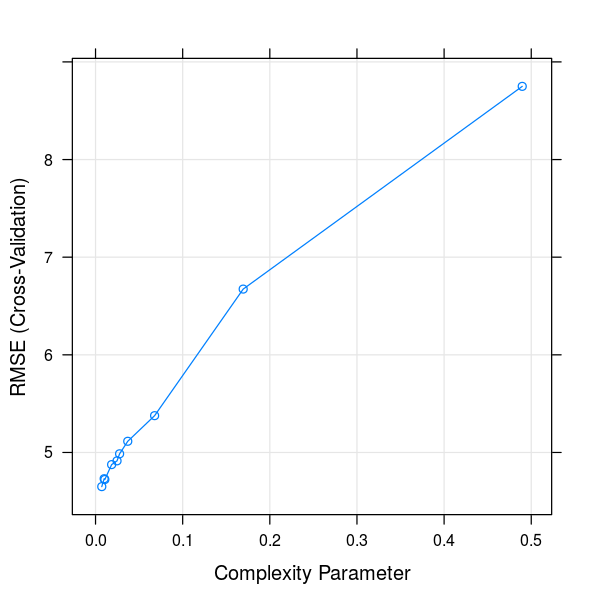

In [24]:
# Fit the model on the training set
set.seed(123)
model <- train(
  medv ~., data = train.data, method = "rpart",
  trControl = trainControl("cv", number = 10),
  tuneLength = 10
  )
# Plot model error vs different values of
# cp (complexity parameter)
plot(model)
# Print the best tuning parameter cp that
# minimize the model RMSE
model$bestTune

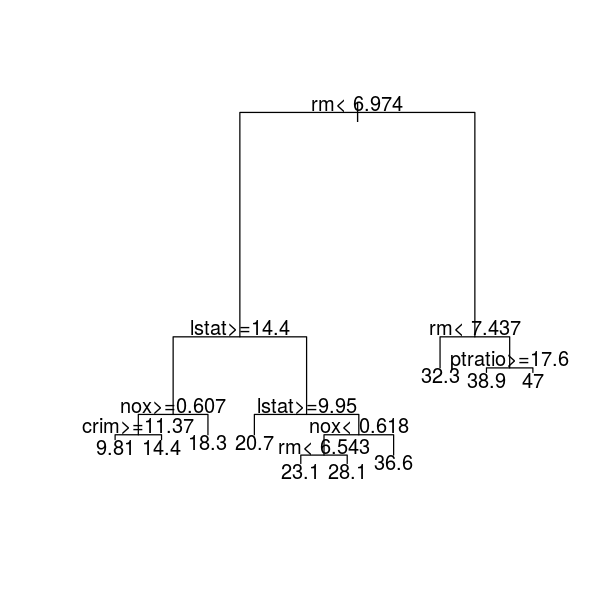

In [25]:
# Plot the final tree model
par(xpd = NA) # Avoid clipping the text in some device
plot(model$finalModel)
text(model$finalModel, digits = 3)

In [27]:
# Decision rules in the model
model$finalModel

n= 407 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 407 35292.0500 22.739310  
   2) rm< 6.974 348 13999.9200 20.056320  
     4) lstat>=14.4 143  2641.2730 15.093010  
       8) nox>=0.607 87   965.8699 12.998850  
        16) crim>=11.36915 26   144.7465  9.811538 *
        17) crim< 11.36915 61   444.4092 14.357380 *
       9) nox< 0.607 56   701.1193 18.346430 *
     5) lstat< 14.4 205  5378.5900 23.518540  
      10) lstat>=9.95 90   492.0000 20.666670 *
      11) lstat< 9.95 115  3581.7470 25.750430  
        22) nox< 0.618 108  1736.0900 25.050000  
          44) rm< 6.543 65   494.5222 23.052310 *
          45) rm>=6.543 43   590.0507 28.069770 *
        23) nox>=0.618 7   975.1771 36.557140 *
   3) rm>=6.974 59  4011.4950 38.564410  
     6) rm< 7.437 30   522.6897 32.303330 *
     7) rm>=7.437 29  1096.1900 45.041380  
      14) ptratio>=17.6 7   465.9686 38.885710 *
      15) ptratio< 17.6 22   280.5800 47.000000 *

In [29]:
# Make predictions on the test data
predictions <- model %>% predict(test.data)
head(predictions)

3        5       11       12       14       15 
32.30333 32.30333 18.34643 20.66667 23.05231 20.66667

In [30]:
# Compute the prediction error RMSE
RMSE(predictions, test.data$medv)

[1] 4.545207